In [1]:
import pandas as pd

import seaborn as sns

from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

import scipy.stats as sps

import numpy as np

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import sklearn.cluster as sklc
import sklearn.metrics as sklm
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

import matplotlib.cm
import matplotlib.pyplot as plt
from matplotlib import colors

import seaborn as sn

pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
plt.style.use('ggplot') # specifies that graphs should use ggplot styling
%matplotlib inline

In [2]:
import statsmodels
print(statsmodels.__version__)

0.12.2


# read the file

In [3]:
birth_data = pd.read_csv('C:/CASA/CASA 007/assessment/solo/CASA007_Assessment/dataset.csv')

In [4]:
birth_data['working_hour'] = birth_data['working_hour'].astype(np.float64)
birth_data['house_price'] = birth_data['house_price'].astype(np.float64)

In [5]:
birth_data.head()

,month,birth_number,CPI,employ_rate(%),unemploy_male(%),unemploy_famale(%),gender_pay_gap(%),working_hour,house_price,Nursery (Under two),Nursery (Two_and_over),weekly_childcost_childminder(Under two),Childminder (Two_and_over),covid_cumulative_model
0,Jan,4683,4.0000,71.0000,9.2000,6.6000,10.5000,36.4000,"150,490.0000",96.0000,94.0000,90.0000,88.0000,0
1,Feb,4615,4.4000,71.0000,9.3000,6.8000,10.5000,36.4000,"147,862.0000",96.0000,94.0000,90.0000,88.0000,0
2,Mar,4923,4.0000,70.8000,9.1000,6.5000,10.5000,36.4000,"142,143.0000",96.0000,94.0000,90.0000,88.0000,0
3,Apr,4689,4.5000,71.4000,8.9000,6.7000,10.5000,36.3000,"151,501.0000",96.0000,94.0000,90.0000,88.0000,0
4,May,4927,4.5000,71.6000,8.6000,6.8000,10.5000,36.3000,"154,317.0000",96.0000,94.0000,90.0000,88.0000,0


In [6]:
birth_data_numeric = pd.get_dummies(birth_data)

In [7]:
birth_data_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 25 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   birth_number                             120 non-null    int64  
 1   CPI                                      120 non-null    float64
 2   employ_rate(%)                           120 non-null    float64
 3   unemploy_male(%)                         120 non-null    float64
 4   unemploy_famale(%)                       120 non-null    float64
 5   gender_pay_gap(%)                        120 non-null    float64
 6   working_hour                             120 non-null    float64
 7   house_price                              120 non-null    float64
 8   Nursery (Under two)                      120 non-null    float64
 9   Nursery (Two_and_over)                   120 non-null    float64
 10  weekly_childcost_childminder(Under two)  120 non-n

In [8]:
birth_data_final = birth_data_numeric

# double check the result
birth_data_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 25 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   birth_number                             120 non-null    int64  
 1   CPI                                      120 non-null    float64
 2   employ_rate(%)                           120 non-null    float64
 3   unemploy_male(%)                         120 non-null    float64
 4   unemploy_famale(%)                       120 non-null    float64
 5   gender_pay_gap(%)                        120 non-null    float64
 6   working_hour                             120 non-null    float64
 7   house_price                              120 non-null    float64
 8   Nursery (Under two)                      120 non-null    float64
 9   Nursery (Two_and_over)                   120 non-null    float64
 10  weekly_childcost_childminder(Under two)  120 non-n

# Data standardization

In [9]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()

birth_data_standardised = birth_data_final.copy()
for c in birth_data_final.columns.values:
    birth_data_standardised[c] = mms.fit_transform(birth_data_final[c].values.reshape(-1,1))
birth_data_standardised.head()

,birth_number,CPI,employ_rate(%),unemploy_male(%),unemploy_famale(%),gender_pay_gap(%),working_hour,house_price,Nursery (Under two),Nursery (Two_and_over),...,month_Dec,month_Feb,month_Jan,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sept
0,0.7480,0.7736,0.1091,0.9219,0.7273,1.0000,0.8478,0.1475,0.0000,0.0000,...,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.7072,0.8491,0.1091,0.9375,0.7636,1.0000,0.8478,0.1011,0.0000,0.0000,...,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.8924,0.7736,0.0727,0.9062,0.7091,1.0000,0.8478,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000
3,0.7517,0.8679,0.1818,0.8750,0.7455,1.0000,0.8261,0.1654,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.8948,0.8679,0.2182,0.8281,0.7636,1.0000,0.8261,0.2152,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000


# Correlation Matrix

Text(0.5, 1.0, 'Correlation Matrix')

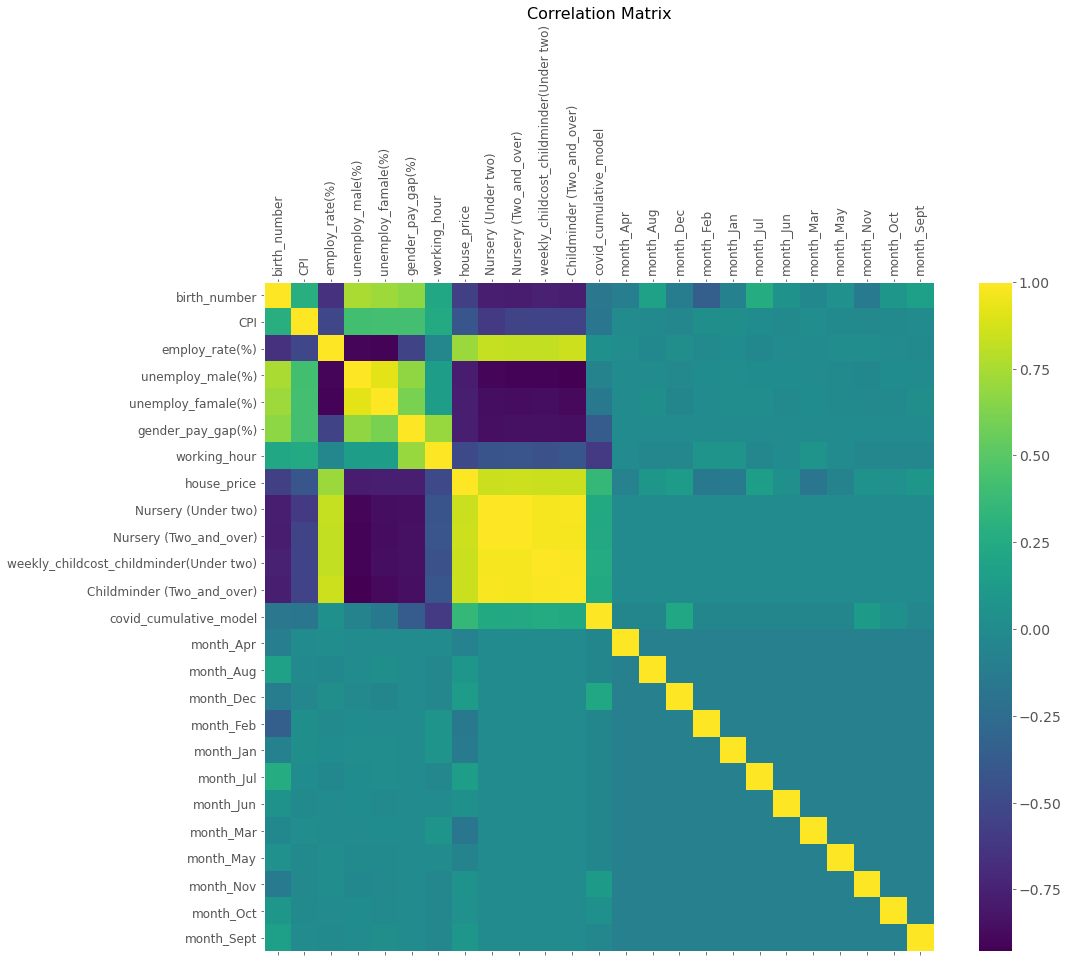

In [10]:
df = birth_data_standardised
plt.rcParams["axes.grid"] = False
f = plt.figure(figsize=(16, 12))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.shape[1]), df.columns, fontsize=12, rotation=90)
plt.yticks(range(df.shape[1]), df.columns, fontsize=12)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

# Using VIF

In [11]:
# calculating VIF
# This function is adjusted from: https://stackoverflow.com/a/51329496/4667568
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data. add_constant is a function from statsmodels (see the import above)
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

In [12]:
birth_data_VIF = drop_column_using_vif_(birth_data_standardised.drop('birth_number', axis=1))

Dropping: month_Apr
Dropping: Nursery (Under two)
Dropping: Childminder (Two_and_over)
Dropping: weekly_childcost_childminder(Under two)
Dropping: Nursery (Two_and_over)
Dropping: unemploy_male(%)
Dropping: employ_rate(%)
Dropping: house_price


d:\Anaconda\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
d:\Anaconda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [13]:
birth_data_VIF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CPI                     120 non-null    float64
 1   unemploy_famale(%)      120 non-null    float64
 2   gender_pay_gap(%)       120 non-null    float64
 3   working_hour            120 non-null    float64
 4   covid_cumulative_model  120 non-null    float64
 5   month_Aug               120 non-null    float64
 6   month_Dec               120 non-null    float64
 7   month_Feb               120 non-null    float64
 8   month_Jan               120 non-null    float64
 9   month_Jul               120 non-null    float64
 10  month_Jun               120 non-null    float64
 11  month_Mar               120 non-null    float64
 12  month_May               120 non-null    float64
 13  month_Nov               120 non-null    float64
 14  month_Oct               120 non-null    fl

# T-test

In [14]:
model_birth_data = sm.OLS(endog=birth_data_final['birth_number'], exog=sm.add_constant(birth_data_VIF)).fit()
model_birth_data.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           birth_number   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     48.78
Date:                Mon, 16 Jan 2023   Prob (F-statistic):           1.17e-40
Time:                        13:03:43   Log-Likelihood:                -747.62
No. Observations:                 120   AIC:                             1529.
Df Residuals:                     103   BIC:                             1577.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   3825.0566     82.617     46.299      0.000    3661.205    3988.908
CPI                     -106.2095     57.069     -1.861      0.066    -219.393       6.974
unemploy_famale(%)       506.9127     66.794      7.589      0.000     374.442     639.383
gender_pay_gap(%)        841.0507    101.384      8.296      0.000     639.979    1042.122
working_hour            -307.2824    114.854     -2.675      0.009    -535.067     -79.498
covid_cumulative_model   132.1191    148.272      0.891      0.375    -161.944     426.182
month_Aug                317.1494     59.366      5.342      0.000     199.412     434.887
month_Dec                 -6.8365     60.850     -0.112      0.911    -127.517     113.844
month_Feb               -262.4307     59.606     -4.403      0.000    -380.645    -144.216
month_Jan                 37.3743     59.666      0.626      0.532     -80.958     155.707
month_Jul                431.3049     59.353      7.267      0.000     313.592     549.018
month_Jun                191.9067     59.319      3.235      0.002      74.262     309.551
month_Mar                102.7153     59.642      1.722      0.088     -15.571     221.001
month_May                185.8292     59.319      3.133      0.002      68.184     303.475
month_Nov                -30.6845     59.866     -0.513      0.609    -149.415      88.046
month_Oct                226.6043     59.444      3.812      0.000     108.712     344.497
month_Sept               301.6040     59.347      5.082      0.000     183.903     419.304
==============================================================================
Omnibus:                       12.010   Durbin-Watson:                   0.913
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.571
Skew:                          -0.632   Prob(JB):                      0.00113
Kurtosis:                       4.057   Cond. No.                         25.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Residual Analysis

<ipython-input-15-b0c29feb73a7>:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


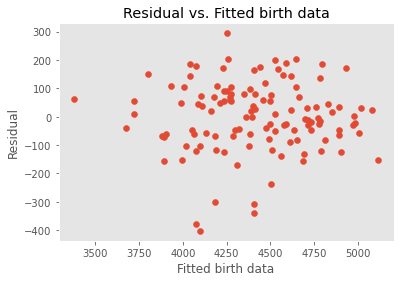

<Figure size 1152x864 with 0 Axes>

In [15]:
plt.scatter(model_birth_data.fittedvalues, model_birth_data.resid)
plt.xlabel('Fitted birth data')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted birth data')
f = plt.figure(figsize=(16, 12))
f.show()

In [18]:
statsmodels.stats.stattools.durbin_watson(model_birth_data.resid)

0.9131103273641097